In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from states import make_state
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import curve_fit
from os import makedirs
import matplotlib.pyplot as plt
import measures as ms
import numpy as np
%matplotlib inline


from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "axes.labelsize": 9,
    'axes.titlesize': 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)

In [2]:
from matrix import ops, listkron, isherm, op_on_state
from measures import get_rhoj, init_rhoj, get_expectation
from states import make_state, bvecs
from scipy.linalg import expm

In [3]:
def iterate(psi, Uj, ts):
    psi = listkron([bvecs["0"], psi, bvecs["0"]])
    L = int(np.log2(len(psi)))
    yield psi
    for t in range(len(ts)-1):
        for p in (1, 0):
            for j in range(1, L-1):
                Nj = [(j-1)%L, j, (j+1)%L]
                if j%2 == p:
                    psi = op_on_state(Uj, Nj, psi)
        yield psi


In [14]:
Omega = 2
V = 863e3/(5.4)**6
Delta = -1*V
dt = 0.1
L = 11
T = 100

ts = np.arange(0, T+dt, dt)


O1 = "IXI"
O2 = "I1I"
O3a = "I11"
O3b = "11I"

Os = [O1, O2, O3a, O3b]
fs = [Omega/2, Delta, V/2, V/2]

Hj = np.zeros((2**3, 2**3), dtype=complex)

for f, O in zip(fs, Os):
    Hj += f*listkron(ops[o] for o in O)
    
    
    
    
Uj = expm(-1j*dt*Hj)

psi0 =  make_state(L,"c3_f1")

rhoj = init_rhoj(L+2, len(ts))

for ti, psi in enumerate(iterate(psi0, Uj, ts)):
    rhoj[ti] = get_rhoj(psi)
            
            
            

In [18]:
def Vfunc(j, k):
    d = np.abs(j - k)
    return 863e3 / (5.4 * d)**6

In [3]:
def iterate_full(psi, U, ts):
    #psi = listkron([bvecs["0"], psi, bvecs["0"]])
    yield psi
    for t in range(len(ts)-1):
        psi = U.dot(psi)
        yield psi

In [36]:
Omega = 2
Delta = -1*Vfunc(1, 2)
dt = 1
L = 11
T = 100

n = "1"  # 1 = |1><1|,  0 = |0><0|

H = np.zeros((2**L, 2**L), dtype=complex)
for j in range(L):
    str1 = ["I"]*L
    str2 = ["I"]*L
    str1[j] = "X"
    str2[j] = n
    OP1 = Omega/2 * listkron([ops[o] for o in str1])
    OP2 = Delta * listkron([ops[o] for o in str2])
    H += OP1
    H += OP2
    for k in range(j+1, L):
        str3= ["I"]*L
        if np.abs(j - k) <= 2:
            str3[j] = n
            str3[k] = n
            OP3 = Vfunc(j, k) * listkron([ops[o] for o in str3])
            H += OP3

            
U = expm(-1j * dt * H)
ts = np.arange(0, T+dt, dt)

In [37]:
psi0 =  make_state(L,"c3_f1")
rhoj = init_rhoj(L, len(ts))
for ti, psi in enumerate(iterate_full(psi0, U, ts)):
    rhoj[ti] = get_rhoj(psi)

In [15]:
exp_z = np.array([get_expectation(rho, ops["Z"]) for rho in rhoj])

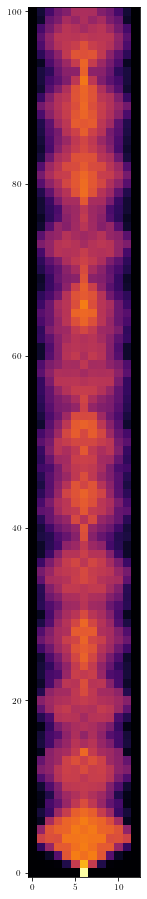

In [16]:
fig, ax = plt.subplots(1,1,figsize=(100, 16))
plt.imshow(exp_z[::10], origin="lower", cmap="inferno_r", clim=[-1, 1])

In [19]:
Vfunc(1,2)

34.80552883200763